<center><h1>In the name of Allah</h1></center>

Name: Reza Vahidimajd

Student Number: 99102491

In this notebook, you will explore adversarial attacks and training methods in deep learning. First, you will train a simple model, ResNet18, on the CIFAR-10 dataset. Next, you will learn about two different adversarial attacks: FGSM (Fast Gradient Sign Method) and PGD (Projected Gradient Descent). To enhance your understanding, you will implement the PGD attack from scratch, while the FGSM attack will be implemented using a library. After this, you will use the FGSM attack to generate adversarial examples and then perform adversarial training on the model using the CIFAR-10 dataset. Finally, you will compare the performance and robustness of the adversarially trained model with the original model.

Good luck!

## outline
- Train Resnet on CIFAR10
- FGSM Attack using torchattacks
- PGD Attack from scratch
- Visualization
- Adversarial Training


In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.autograd import Variable
from tqdm import tqdm

In [4]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


## Train Resnet on CIFAR10 (15 pts)

In [5]:
# Prepare Cifar10 data
batch_size = 128
transform = transforms.Compose([transforms.ToTensor(),])

##############################################################################
# Prepare training and test datasets and dataloaders                         #
##############################################################################
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
################################ End #########################################

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# model architecture
class resnet(nn.Module):
  def __init__(self, num_cls):
    super().__init__()
    self.conv = nn.Sequential(*list(resnet18(weights=None).children())[:-2])
    self.fc = nn.Linear(512, num_cls)

  def forward(self, x):
    x = self.conv(x)
    x = torch.flatten(x, start_dim=1)
    logits = self.fc(x)
    return logits

##############################################################################
# Initialize model and move to device                                        #
##############################################################################
model = resnet(num_cls=10).to(device)

################################ End #########################################

In [8]:
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
epochs = 100

In [9]:
##############################################################################
# Implement train loop and log training loss after each epoch                #
##############################################################################


def train(model, trainloader, criterion, optimizer, device, epochs=100):
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f'Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}')
        running_loss = 0.0


train(model, trainloader, criterion, optimizer, device, epochs)




################################ End #########################################

Epoch 1, Loss: 1.5266959717511521
Epoch 2, Loss: 1.1063767145661747
Epoch 3, Loss: 0.9021100385109787
Epoch 4, Loss: 0.7574721647955268
Epoch 5, Loss: 0.6424690129811806
Epoch 6, Loss: 0.538284947652646
Epoch 7, Loss: 0.4505651213247758
Epoch 8, Loss: 0.3640314477026615
Epoch 9, Loss: 0.3032210869023867
Epoch 10, Loss: 0.2482031545866176
Epoch 11, Loss: 0.1957485414660343
Epoch 12, Loss: 0.1794264064553906
Epoch 13, Loss: 0.12854570984992836
Epoch 14, Loss: 0.11504154371293
Epoch 15, Loss: 0.0992951709062547
Epoch 16, Loss: 0.09096886111361444
Epoch 17, Loss: 0.0725732482636295
Epoch 18, Loss: 0.06839044120810601
Epoch 19, Loss: 0.05178186815241566
Epoch 20, Loss: 0.06372897059458982
Epoch 21, Loss: 0.05140955358162484
Epoch 22, Loss: 0.044897666607109254
Epoch 23, Loss: 0.04149491698516871
Epoch 24, Loss: 0.02736978224196407
Epoch 25, Loss: 0.028630336870432205
Epoch 26, Loss: 0.030164436974307842
Epoch 27, Loss: 0.029721924260108615
Epoch 28, Loss: 0.03019047557236984
Epoch 29, Loss:

In [10]:
##############################################################################
# Evaluate the trained model on test set and print test accuracy             #
##############################################################################

def test(model, testloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted = torch.argmax(outputs, dim=1)
            total += labels.shape[0]
            correct += (predicted == labels).sum().item()

    print(f'test accuracy: {100 * correct / total}%')

test(model, testloader, device)

################################ End #########################################

test accuracy: 75.4%


In [11]:
# Save model
model.eval()
model_name = "resnet18_cifar10_model_pretrained.pth"
model_PATH = f"{model_name}"
torch.save(model.state_dict(), model_PATH)

## FGSM Attack using torchattacks (10 pts)

In [9]:
model = resnet(num_cls=10)
model.load_state_dict(torch.load("/content/drive/MyDrive/resnet18_cifar10_model_pretrained.pth", map_location=torch.device('cpu')))
model = model.to(device)

In this section you should run FGSM attack using torchattacks library (https://adversarial-attacks-pytorch.readthedocs.io/en/latest/index.html).

Run the attack for $\epsilon \in \{\frac{1}{255}, \frac{4}{255}, \frac{8}{255},\}$ report the performance of the model on untargeted FGSM attack on the test data.

In [12]:
!pip install torchattacks

In [13]:
##############################################################################
# run untargeted FGSM attack for epsilon = 1/255 and report its accuracy     #
##############################################################################
from torchattacks import FGSM

def evaluate_FGSM_attack(adversary, data_loader):
    correct_predictions = 0
    total_samples = 0
    model.eval()

    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        adversarial_images = adversary(images, labels)
        outputs = model(adversarial_images)
        _, predicted = torch.max(outputs.data, 1)

        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    print(f'Epsilon: {adversary.eps:.6f}, Accuracy: {100 * correct_predictions / total_samples}')



epsilon = 1/255
attack = FGSM(model, eps=epsilon)
evaluate_FGSM_attack(attack, testloader)


################################ End #########################################

Epsilon: 0.003922, Accuracy: 53.69


In [14]:
##############################################################################
# run untargeted FGSM attack for epsilon = 4/255 and report its accuracy     #
##############################################################################

epsilon = 4/255
attack = FGSM(model, eps=epsilon)
evaluate_FGSM_attack(attack, testloader)




################################ End #########################################

Epsilon: 0.015686, Accuracy: 23.99


In [15]:
##############################################################################
# run untargeted FGSM attack for epsilon = 8/255 and report its accuracy     #
##############################################################################



epsilon = 8/255
attack = FGSM(model, eps=epsilon)
evaluate_FGSM_attack(attack, testloader)



################################ End #########################################

Epsilon: 0.031373, Accuracy: 12.39


## PGD Attack from scratch (30 pts)

In this section you should implement PGD attack from scratch.

In [20]:
import torch
import torch.nn.functional as F

class LinfPGDAttack(object):

    def __init__(self, model, epsilon=8/255, k=2, alpha=2/255):
        self.model = model
        self.epsilon = epsilon
        self.steps = k
        self.alpha = alpha

    def __call__(self, image, label):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        image = image.to(device)
        label = label.to(device)

        out = self.model(image)
        _, pred = torch.max(out, 1)

        perturbed_image = image.clone()
        perturbed_image.requires_grad = True
        perturbed_image = perturbed_image.to(device)

        if pred.item() == label.item():
            ##############################################################################
            # Implement a k step PGD attack of size alpha                                #
            # while always staying within epsilon distance from the initial point        #
            # Use cross entropy loss                                                     #
            ##############################################################################

            for _ in range(self.steps):
                perturbed_image.requires_grad = True
                out = self.model(perturbed_image)
                loss = F.cross_entropy(out, label)

                self.model.zero_grad()
                loss.backward()
                with torch.no_grad():
                    perturbed_image = perturbed_image.data + self.alpha * perturbed_image.grad.data.sign()

                    perturbed_image = torch.clamp(perturbed_image, image - self.epsilon, image + self.epsilon)

                    perturbed_image = torch.clamp(perturbed_image.data, 0, 1)

            ################################ End #########################################

        return perturbed_image


In [30]:
##############################################################################
# Evaluate PGD attack on the trained model with k=2,4,8                      #
##############################################################################

k_list = [2,4,8]

##############################################################################

def evaluate_pgd_attack(model, test_loader, k_list, epsilon=8/255, alpha=2/255):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    results = {}
    for k in k_list:
        pgd_attack = LinfPGDAttack(model, epsilon=epsilon, k=k, alpha=alpha)
        correct = 0
        total = 0

        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            for i in range(images.size(0)):
                image = images[i].unsqueeze(0)
                label = labels[i].unsqueeze(0)
                adv_image = pgd_attack(image, label)
                outputs = model(adv_image)
                predicted = torch.argmax(outputs, dim=1)
                total += label.size(0)
                correct += (predicted == label).sum().item()

        accuracy = 100 * correct / total
        results[k] = accuracy
        print(f'PGD Attack with k={k}: Accuracy = {accuracy:.2f}%')

    return results

results = evaluate_pgd_attack(model, testloader, k_list)

################################ End #########################################

PGD Attack with k=2: Accuracy = 15.34%
PGD Attack with k=4: Accuracy = 2.47%
PGD Attack with k=8: Accuracy = 0.45%


## Visualization (10 pts)

Implement a function to plot the original image, the perturbed imaged and their predicted labels by the model

In [13]:
##############################################################################
# Implement the function described                                           #
##############################################################################


import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms

def plot_images_with_predictions(original_image, perturbed_image, label, pred_label):

    original_image = original_image.squeeze().cpu().numpy().transpose((1, 2, 0))
    perturbed_image = perturbed_image.squeeze().cpu().numpy().transpose((1, 2, 0))

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(original_image)
    axes[0].set_title(f'Original Image\nTrue: {label}')
    axes[0].axis('off')

    axes[1].imshow(perturbed_image)
    axes[1].set_title(f'Perturbed Image\nPredicted: {pred_label}')
    axes[1].axis('off')

    plt.show()




################################ End #########################################

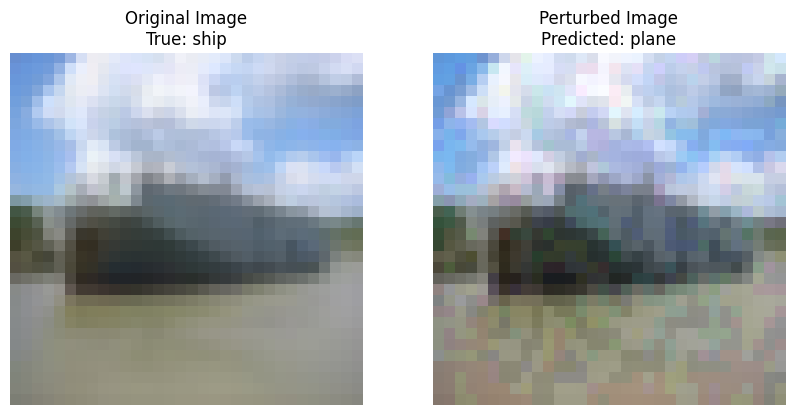

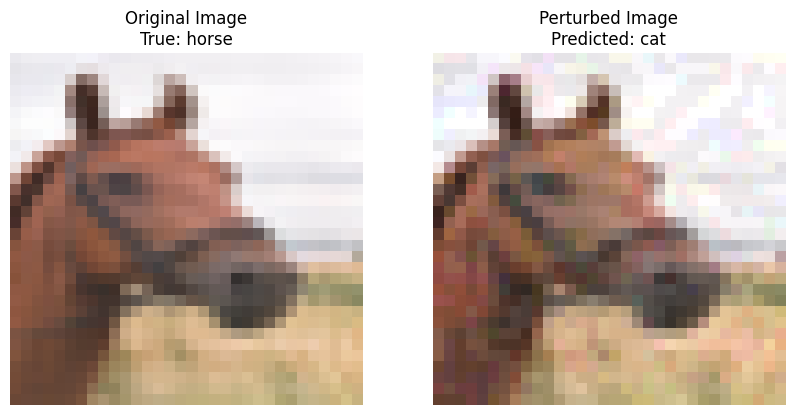

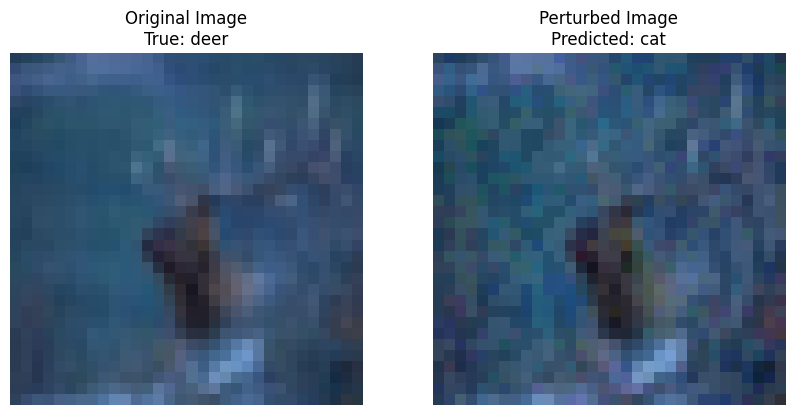

In [50]:
##############################################################################
# Choose 3 random images from testset and run FGSM attack and visualize      #
##############################################################################
import random

epsilon = 8/255
fgsm = FGSM(model, eps=epsilon)
model.eval()

all_images, all_labels = next(iter(testloader))
random_indices_FGSM = random.sample(range(len(all_images)), 3)
example_images_FGSM = all_images[random_indices_FGSM]
example_labels_FGSM = all_labels[random_indices_FGSM]

for i in range(3):
    image = example_images_FGSM[i].to(device)
    label = torch.tensor([example_labels_FGSM[i]]).to(device)
    image = image.unsqueeze(0).to(device)
    adv_image = fgsm(image, label)
    original_output = model(image)
    perturbed_output = model(adv_image)
    original_pred = torch.argmax(original_output, dim=1).item()
    perturbed_pred = torch.argmax(perturbed_output, dim=1).item()
    plot_images_with_predictions(image, adv_image, classes[original_pred], classes[perturbed_pred])


################################ End #########################################

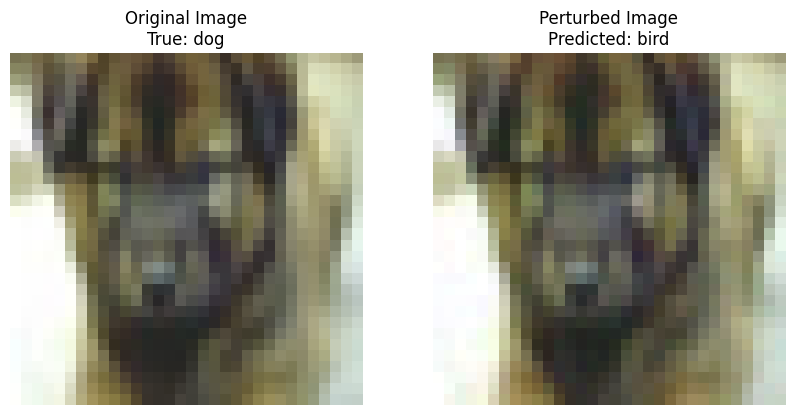

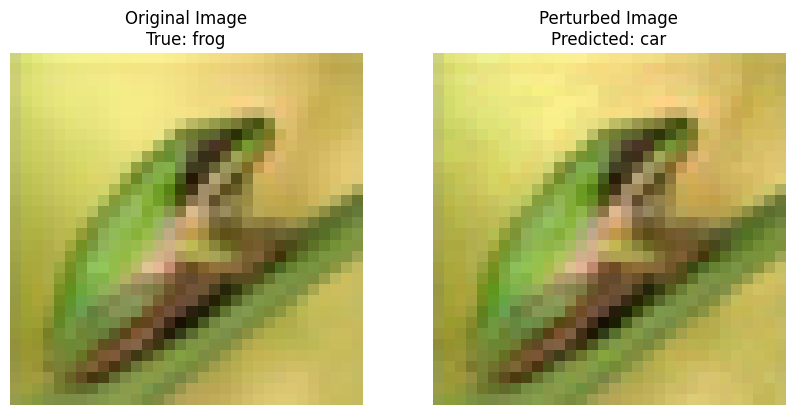

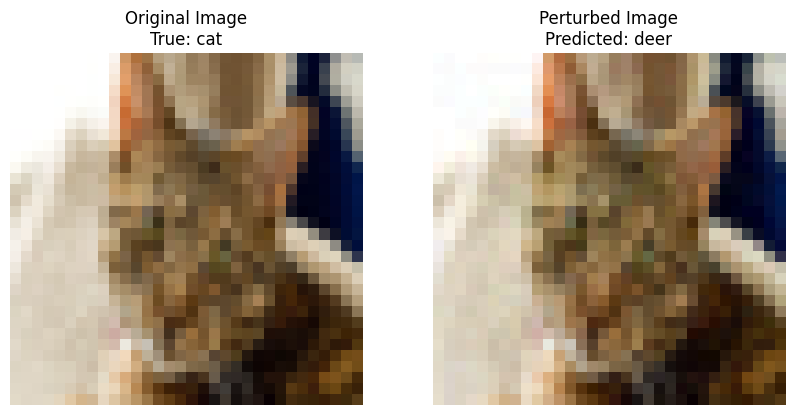

In [22]:
##############################################################################
# Choose 3 random images from testset and run PGD attack and visualize      #
##############################################################################



import random

pgd_attack = LinfPGDAttack(model, epsilon=8/255, k=2, alpha=2/255)
model.eval()

all_images, all_labels = next(iter(testloader))
random_indices_FGSM = random.sample(range(len(all_images)), 3)
example_images_FGSM = all_images[random_indices_FGSM]
example_labels_FGSM = all_labels[random_indices_FGSM]

for i in range(3):
    image = example_images_FGSM[i].to(device)
    label = torch.tensor([example_labels_FGSM[i]]).to(device)
    image = image.unsqueeze(0).to(device)
    adv_image = pgd_attack(image, label)
    original_output = model(image)
    perturbed_output = model(adv_image)
    original_pred = torch.argmax(original_output, dim=1).item()
    perturbed_pred = torch.argmax(perturbed_output, dim=1).item()
    plot_images_with_predictions(image, adv_image, classes[original_pred], classes[perturbed_pred])



################################ End #########################################

## Adversarial Training (35 pts)

In this section you are going to adversarially train your model and see the results.

In [16]:
##############################################################################
# Load a new resnet model for adversarial training                           #
# Train the model on perturbed images from                                   #
# untargeted FGSM attack with epsilon = 8/255 on train dataset               #
# Also use the following setup for training the model                        #
##############################################################################

from torchattacks import FGSM

adv_model = resnet(num_cls=10) # Your code goes here
adv_model.to(device)

learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(adv_model.parameters(), lr=learning_rate, momentum=0.9)
epochs = 100


# Your code goes here

adv_model.train()
epsilon = 8/255
fgsm_attack = FGSM(adv_model, eps=epsilon)

for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        perturbed_images = fgsm_attack(images, labels)

        optimizer.zero_grad()

        outputs = adv_model(perturbed_images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(trainloader):.4f}')

################################ End #########################################

Epoch [1/100], Loss: 2.1251
Epoch [2/100], Loss: 1.9905
Epoch [3/100], Loss: 1.9359
Epoch [4/100], Loss: 1.8962
Epoch [5/100], Loss: 1.8491
Epoch [6/100], Loss: 1.8195
Epoch [7/100], Loss: 1.7816
Epoch [8/100], Loss: 1.7536
Epoch [9/100], Loss: 1.7174
Epoch [10/100], Loss: 1.6893
Epoch [11/100], Loss: 1.6523
Epoch [12/100], Loss: 1.6185
Epoch [13/100], Loss: 1.5836
Epoch [14/100], Loss: 1.5505
Epoch [15/100], Loss: 1.5126
Epoch [16/100], Loss: 1.4804
Epoch [17/100], Loss: 1.4387
Epoch [18/100], Loss: 1.3992
Epoch [19/100], Loss: 1.3583
Epoch [20/100], Loss: 1.3165
Epoch [21/100], Loss: 1.2805
Epoch [22/100], Loss: 1.2436
Epoch [23/100], Loss: 1.2022
Epoch [24/100], Loss: 1.1668
Epoch [25/100], Loss: 1.1225
Epoch [26/100], Loss: 1.0908
Epoch [27/100], Loss: 1.0538
Epoch [28/100], Loss: 1.0178
Epoch [29/100], Loss: 0.9925
Epoch [30/100], Loss: 0.9568
Epoch [31/100], Loss: 0.9275
Epoch [32/100], Loss: 0.8987
Epoch [33/100], Loss: 0.8576
Epoch [34/100], Loss: 0.8390
Epoch [35/100], Loss: 0

In [17]:
##############################################################################
# Evaluate the new model on the test dataset                                 #
##############################################################################

# Your code goes here

def evaluate_model(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')

evaluate_model(adv_model, testloader)

################################ End #########################################

Accuracy: 60.95%


In [18]:
##############################################################################
# Run FGSM attack on the adversarially trained model with epsilon = 8/255    #
##############################################################################

# Your code goes here

def FGSM_attack(model, data_loader, attack):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        adv_images = attack(images, labels)
        outputs = model(adv_images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')


epsilon = 8/255
attack = FGSM(adv_model, eps=epsilon)
FGSM_attack(adv_model, testloader, attack)


################################ End #########################################

Accuracy: 23.69%


In [21]:
##############################################################################
#  Run PGD attack on the adversarially trained model with k=4                #
##############################################################################

# Your code goes here

def PGD_attack(model, data_loader, attack):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        for i in range(images.size(0)):
            image = images[i].unsqueeze(0)
            label = labels[i].unsqueeze(0)
            adv_images = attack(image, label)
            outputs = model(adv_images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')


epsilon = 8/255
alpha = 2 / 255
attack = LinfPGDAttack(adv_model, epsilon=epsilon, k=4, alpha=alpha)
PGD_attack(adv_model, testloader, attack)

################################ End #########################################

Accuracy: 10.13%


Answer the following questions:
- What happened to the accuracy of the adversarially trained model?
The accuracy of the adversarially trained model on clean data was slightly lower than that of a normally trained model because the adversarial training process can introduce some regularization effects that slightly degrade performance on clean data and The accuracy of the adversarially trained model on adversarial data was significantly higher compared to a non-adversarially trained model. This is because the model has learned to recognize and correctly classify inputs even when small adversarial perturbations are present.
- What do you conclude from the result of the FGSM attack on the adversarially trained model?
An adversarially trained model should show higher resilience to FGSM attacks compared to a non-adversarially trained model. This means that the decrease in accuracy when subjected to FGSM attacks was less pronounced for the adversarially trained model.
- What do you conclude from the result of the PGD attack on the adversarially trained model?
The accuracy of the adversarially trained model under PGD attacks was lower than under FGSM attacks because PGD is a stronger attack
- What is you final conclusion?
Adversarial training significantly enhances the robustness of the model against adversarial attacks like FGSM and PGD and the adversarially trained model demonstrates resilience to common adversarial attacks